In [1]:
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
)
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler

In [2]:
# CoW
pd.options.mode.copy_on_write = True


In [3]:
# Random Seed
random_state = 33
np.random.seed(random_state)

In [4]:
# plt style
plt.style.use("seaborn-v0_8-darkgrid")

### Dataset

In [47]:
# Dataset
PROJECT_DIR = Path.cwd().parent

# parq_path = PROJECT_DIR / "data" / "all_stats.parquet"
parq_path = PROJECT_DIR / "data" / "combined_stats.parquet"
df = pd.read_parquet(parq_path)
# df.head()

In [46]:
### uncomment to run specific hierarhcy ###
# # Dislplay labels by hierarchy
# csv_path = PROJECT_DIR / "data" / "all_flights/all_flights" / "flight_header.csv"

# flight_header_df = pd.read_csv(csv_path)
# hierarchy_df = flight_header_df.groupby(["hierarchy", "label"]).size()
# hierarchy_df


In [7]:
# Get labels for hierarchy
# ### change here to run different hierarchy ###
# hierarchy = "baffle"

# hierarchy_df = hierarchy_df.reset_index(name="Count")
# mask = hierarchy_df["hierarchy"] == hierarchy
# labels = hierarchy_df.loc[mask, "label"].to_list()
# print(labels)

# # Filter df by hierarchy labels
# label_mask = df["label"].isin(labels)
# before_after_mask = df["before_after"].isin(["before", "after"])
# df_filtered = df[label_mask & before_after_mask]

In [48]:
### train using all data ###
hierarchy = None

# filter data before/after
before_after_mask = df["before_after"] != "same"

# filter data +-N days
num_days = 2
date_diff_mask = (df["date_diff"] >= -num_days) & (df["date_diff"] <= num_days)

df_filtered = df[before_after_mask & date_diff_mask]

In [49]:
df_filtered.shape

(16728, 211)

In [50]:
# Add target column
df_filtered["target"] = df_filtered["before_after"].map({"before": 1, "after": 0})

In [51]:
df_filtered["before_after"].unique()

array(['before', 'after'], dtype=object)

In [ ]:
df_filtered["date_diff"].unique()  # 0 is same day

array([-1, -2,  0,  1,  2])

In [ ]:
# all features
all_features = [
    "AltMSL_max",
    "AltMSL_mean",
    "AltMSL_min",
    "AltMSL_p25",
    "AltMSL_p75",
    "AltMSL_range",
    "AltMSL_rate_mean",
    "AltMSL_std",
    "E1_CHT1_EGT1_ratio_mean",
    "E1_CHT1_deviation",
    "E1_CHT1_max",
    "E1_CHT1_mean",
    "E1_CHT1_min",
    "E1_CHT1_p25",
    "E1_CHT1_p75",
    "E1_CHT1_std",
    "E1_CHT2_CHT4_corr",
    "E1_CHT2_max",
    "E1_CHT2_mean",
    "E1_CHT2_min",
    "E1_CHT2_p25",
    "E1_CHT2_p75",
    "E1_CHT2_std",
    "E1_CHT3_max",
    "E1_CHT3_mean",
    "E1_CHT3_min",
    "E1_CHT3_p25",
    "E1_CHT3_p75",
    "E1_CHT3_std",
    "E1_CHT4_EGT4_ratio_mean",
    "E1_CHT4_deviation",
    "E1_CHT4_max",
    "E1_CHT4_mean",
    "E1_CHT4_min",
    "E1_CHT4_p25",
    "E1_CHT4_p75",
    "E1_CHT4_std",
    "E1_CHT_EGT_ratio_mean",
    "E1_CHT_EGT_ratio_std",
    "E1_CHT_OAT_diff_mean",
    "E1_CHT_OAT_ratio_mean",
    "E1_CHT_acceleration",
    "E1_CHT_asymmetry",
    "E1_CHT_cruise_stability",
    "E1_CHT_cv",
    "E1_CHT_max_all",
    "E1_CHT_max_rate_change",
    "E1_CHT_mean_all",
    "E1_CHT_min_all",
    "E1_CHT_p90_p10_spread",
    "E1_CHT_range_iqr",
    "E1_CHT_rate_max",
    "E1_CHT_spread_mean",
    "E1_CHT_spread_p90",
    "E1_CHT_std_all",
    "E1_CHT_threshold",
    "E1_EGT1_EGT3_corr",
    "E1_EGT1_max",
    "E1_EGT1_mean",
    "E1_EGT1_min",
    "E1_EGT1_p25",
    "E1_EGT1_p75",
    "E1_EGT1_std",
    "E1_EGT2_max",
    "E1_EGT2_mean",
    "E1_EGT2_min",
    "E1_EGT2_p25",
    "E1_EGT2_p75",
    "E1_EGT2_std",
    "E1_EGT3_max",
    "E1_EGT3_mean",
    "E1_EGT3_min",
    "E1_EGT3_p25",
    "E1_EGT3_p75",
    "E1_EGT3_std",
    "E1_EGT4_deviation",
    "E1_EGT4_max",
    "E1_EGT4_mean",
    "E1_EGT4_min",
    "E1_EGT4_p25",
    "E1_EGT4_p75",
    "E1_EGT4_std",
    "E1_EGT_cv",
    "E1_EGT_max_all",
    "E1_EGT_max_rate_change",
    "E1_EGT_mean_all",
    "E1_EGT_min_all",
    "E1_EGT_p90_p10_spread",
    "E1_EGT_range_iqr",
    "E1_EGT_rate_max",
    "E1_EGT_spread_mean",
    "E1_EGT_std_all",
    "E1_FFlow_RPM_ratio_std",
    "E1_FFlow_acceleration",
    "E1_FFlow_max",
    "E1_FFlow_mean",
    "E1_FFlow_min",
    "E1_FFlow_p25",
    "E1_FFlow_p75",
    "E1_FFlow_std",
    "E1_OilP_RPM_corr",
    "E1_OilP_RPM_ratio",
    "E1_OilP_instability",
    "E1_OilP_mean",
    "E1_OilP_min",
    "E1_OilP_p25",
    "E1_OilP_p75",
    "E1_OilP_std",
    "E1_OilT_climb_rate",
    "E1_OilT_descend_rate",
    "E1_OilT_max",
    "E1_OilT_mean",
    "E1_OilT_min",
    "E1_OilT_p25",
    "E1_OilT_p75",
    "E1_OilT_rate",
    "E1_OilT_std",
    "E1_OilT_threshold",
    "E1_RPM_cruise_stability",
    "E1_RPM_max",
    "E1_RPM_mean",
    "E1_RPM_min",
    "E1_RPM_p25",
    "E1_RPM_p75",
    "E1_RPM_std",
    "E1_power_metric",
    "E1_specific_fuel_consumption",
    "FQtyL_consumed",
    "FQtyL_end",
    "FQtyL_max",
    "FQtyL_mean",
    "FQtyL_min",
    "FQtyL_p25",
    "FQtyL_p75",
    "FQtyL_rate",
    "FQtyL_start",
    "FQtyL_std",
    "FQtyR_consumed",
    "FQtyR_end",
    "FQtyR_max",
    "FQtyR_mean",
    "FQtyR_min",
    "FQtyR_p25",
    "FQtyR_p75",
    "FQtyR_rate",
    "FQtyR_start",
    "FQtyR_std",
    "IAS_max",
    "IAS_mean",
    "IAS_min",
    "IAS_p25",
    "IAS_p75",
    "IAS_rate_mean",
    "IAS_std",
    "NormAc_max",
    "NormAc_mean",
    "NormAc_min",
    "NormAc_p25",
    "NormAc_p75",
    "NormAc_std",
    "OAT_max",
    "OAT_mean",
    "OAT_min",
    "OAT_p25",
    "OAT_p75",
    "OAT_std",
    "VSpd_max",
    "VSpd_mean",
    "VSpd_min",
    "VSpd_p25",
    "VSpd_p75",
    "VSpd_std",
    "amp1_max",
    "amp1_mean",
    "amp1_min",
    "amp1_negative_ratio",
    "amp1_p25",
    "amp1_p75",
    "amp1_std",
    "amp2_max",
    "amp2_mean",
    "amp2_min",
    "amp2_p25",
    "amp2_p75",
    "amp2_std",
    # "before_after",
    # "date_diff",
    "electrical_load_variance",
    # "flight_id",
    # "flight_length",
    "fuel_imbalance_max",
    "fuel_imbalance_mean",
    "fuel_imbalance_trend",
    "high_power_duration_ratio",
    "high_temp_duration_ratio",
    # "label",
    # "num_flights_before",
    "volt1_amp1_stability",
    "volt1_max",
    "volt1_mean",
    "volt1_min",
    "volt1_p25",
    "volt1_p75",
    # "volt1_rpm_correlation",  # all nan
    "volt1_std",
    "volt2_max",
    "volt2_mean",
    "volt2_min",
    "volt2_p25",
    "volt2_p75",
    "volt2_std",
]

In [56]:
len(all_features)

205

In [71]:
# Split into X, y
X_all = df_filtered[all_features]
y_all = df_filtered["target"]

In [85]:
# Remove rows with any NaN values
X_all.replace([np.inf, -np.inf], np.nan, inplace=True)
nan_mask = ~X_all.isna().any(axis=1)
X = X_all[nan_mask]
y = y_all[nan_mask]

# Check for NaN, inf
assert not X.isna().any().any()
assert not np.isinf(X).any().any()

In [87]:
X_all.shape

(16728, 204)

In [86]:
X.shape

(10124, 204)

In [19]:
y_all.head()

0    1
1    1
3    1
5    0
7    1
Name: target, dtype: int64

In [88]:
assert X_all.shape[0] == y_all.shape[0]

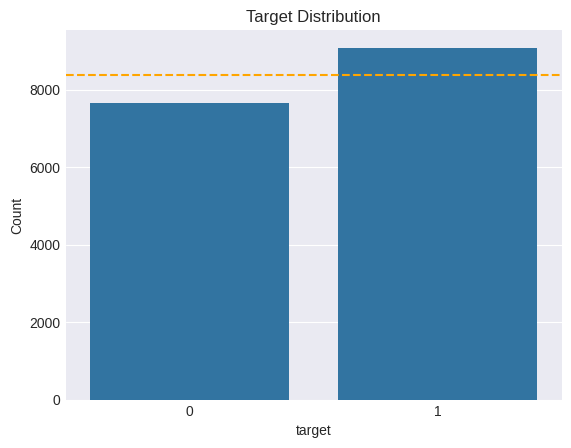

In [89]:
# visualize class distribution
target_df = y_all.to_frame().groupby("target").size()

sns.barplot(data=target_df)
balanced = y_all.size / 2
plt.axhline(y=balanced, linestyle="--", color="orange")
plt.title("Target Distribution")
plt.ylabel("Count");

In [90]:
# Train-Test Split
test_size = 0.20

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)

In [91]:
X_train.shape

(8099, 204)

In [92]:
X_test.shape

(2025, 204)

In [93]:
# Standaridize/scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Baseline Model

In [94]:
# Model
C = 0.1  # C=1/lambda - smaller C means stronger regularization
max_iter = 50_000

log_clf = LogisticRegression(C=C, max_iter=max_iter, random_state=random_state)

In [95]:
# Cross-Validation
cv = 5
scoring = "roc_auc"  # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-string-names
scores = cross_val_score(log_clf, X_train_scaled, y_train, cv=cv, scoring=scoring)

In [96]:
print(f"mean={scores.mean():0.2f}, std={scores.std():0.2f}")

mean=0.75, std=0.01


### Feature Selection

In [97]:
log_clf = LogisticRegression(C=C, max_iter=max_iter, random_state=random_state)
step = 3  # features to add/remove

selector = RFECV(
    estimator=log_clf,
    step=step,
    cv=cv,
    scoring=scoring,
)

# Fit on training data
selector.fit(X_train_scaled, y_train)

# Get results
print(selector.n_features_)
optimal_features = X_train.columns[selector.support_].tolist()

147


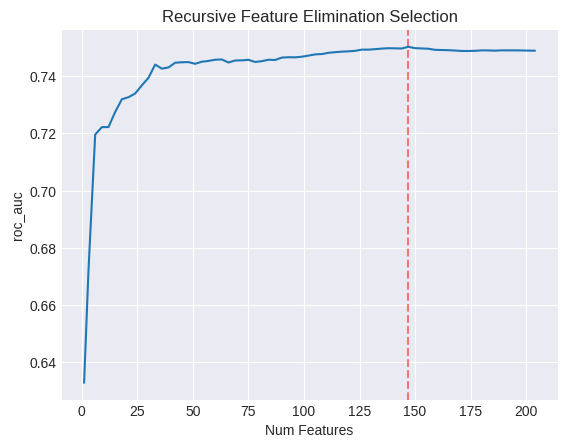

In [98]:
# plot
plt.errorbar(
    x=selector.cv_results_["n_features"],
    y=selector.cv_results_["mean_test_score"],
)
plt.xlabel("Num Features")
plt.ylabel(scoring)
plt.title("Recursive Feature Elimination Selection")
plt.axvline(
    x=selector.n_features_,
    color="r",
    linestyle="--",
    alpha=0.5,
);

In [99]:
# optimal features
X_train_optimal = selector.transform(X_train_scaled)
X_test_optimal = selector.transform(X_test_scaled)

In [100]:
# train with optimal features
log_clf = LogisticRegression(C=0.06, random_state=random_state)

# fit
log_clf.fit(X_train_optimal, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.06
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,33
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


### Model Performance

In [101]:
# predictions
y_train_pred = log_clf.predict(X_train_optimal)
y_test_pred = log_clf.predict(X_test_optimal)

# Get prediction probabilities for ROC analysis
y_train_proba = log_clf.predict_proba(X_train_optimal)
y_test_proba = log_clf.predict_proba(X_test_optimal)

In [102]:
print("Test Classification Report")
print(classification_report(y_test, y_test_pred, zero_division=0))

Test Classification Report
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       998
           1       0.69      0.73      0.71      1027

    accuracy                           0.69      2025
   macro avg       0.70      0.69      0.69      2025
weighted avg       0.69      0.69      0.69      2025



In [103]:
# Print trian/test metrics
metrics = {
    # metric: (function, kwargs)
    "accuracy": (accuracy_score, {}),
    "precision (weighted)": (
        precision_score,
        {"average": "weighted", "zero_division": 0},
    ),
    "recall (weighted)": (recall_score, {"average": "weighted", "zero_division": 0}),
    "f1-score (weighted)": (f1_score, {"average": "weighted", "zero_division": 0}),
    "precision (macro)": (precision_score, {"average": "macro", "zero_division": 0}),
    "recall (macro)": (recall_score, {"average": "macro", "zero_division": 0}),
    "f1-score (macro)": (f1_score, {"average": "macro", "zero_division": 0}),
}

datasets = {
    # data: (y_true, y_pred)
    "train": (y_train, y_train_pred),
    "test": (y_test, y_test_pred),
}

print(f"{'Metric':<16} {'Train':>18} {'Test':>10}")
for metric, (f, kwargs) in metrics.items():
    train_score = f(*datasets["train"], **kwargs)
    test_score = f(*datasets["test"], **kwargs)
    print(f"{metric:<25} {train_score:>10.4f} {test_score:>10.4f}")

Metric                        Train       Test
accuracy                      0.7084     0.6943
precision (weighted)          0.7082     0.6949
recall (weighted)             0.7084     0.6943
f1-score (weighted)           0.7077     0.6938
precision (macro)             0.7080     0.6950
recall (macro)                0.7060     0.6938
f1-score (macro)              0.7064     0.6936


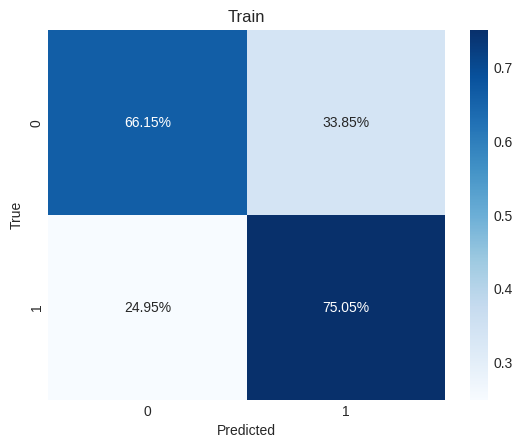

In [104]:
# confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Train Confusion Matrix
cm_train_norm = cm_train.astype("float") / cm_train.sum(axis=1)[:, np.newaxis]

sns.heatmap(
    cm_train_norm,
    annot=True,
    fmt=".2%",
    cmap="Blues",
)
plt.title("Train")
plt.xlabel("Predicted")
plt.ylabel("True");


In [105]:
print("Test accuracy")
for i, target in enumerate(log_clf.classes_):
    accuracy = cm_test[i, i] / cm_test[i].sum() if cm_test[i].sum() > 0 else 0
    print(f"target={int(target)}, {accuracy=:0.3f}")

Test accuracy
target=0, accuracy=0.656
target=1, accuracy=0.731


Text(55.58333333333333, 0.5, 'True')

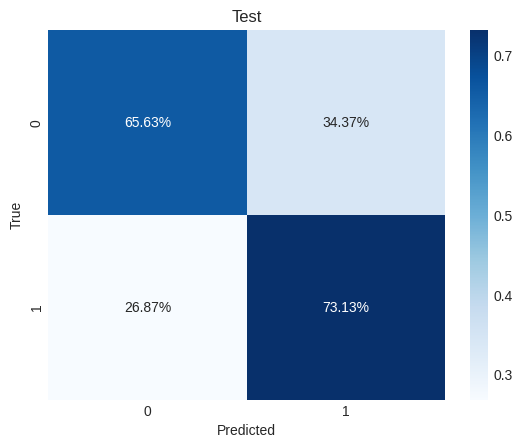

In [ ]:
# Test Confusion Matrix
cm_test_norm = cm_test.astype("float") / cm_test.sum(axis=1)[:, np.newaxis]

sns.heatmap(
    cm_test_norm,
    annot=True,
    fmt=".2%",
    cmap="Blues",
)
plt.title("Test")
plt.xlabel("Predicted")
plt.ylabel("True");

0.76


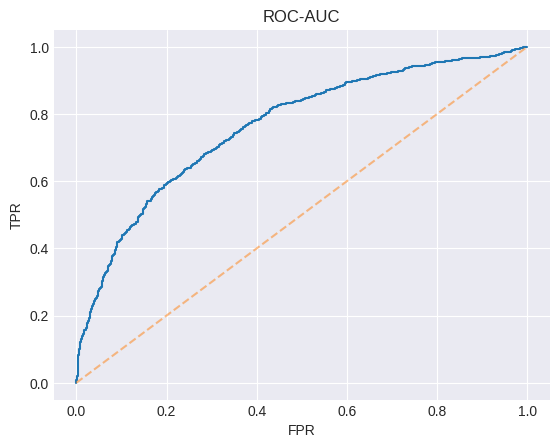

In [107]:
# ROC-AUC
y_scores = y_test_proba[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], "--", alpha=0.5)  # naive baseline
plt.title("ROC-AUC")
plt.xlabel("FPR")
plt.ylabel("TPR")

roc_auc = auc(fpr, tpr)
print(f"{roc_auc:0.2f}")

In [108]:
# Get feature names
features_mask = selector.get_support()
features = X_train.columns[features_mask]


In [109]:
# Create feature df
importance = np.abs(log_clf.coef_).mean(axis=0)
features_df = pd.DataFrame({"feature": features, "importance": importance}).sort_values(
    "importance", ascending=False
)
features_df.head(10)

,feature,importance
82,E1_OilP_std,1.429923
96,E1_RPM_std,0.719653
76,E1_OilP_RPM_ratio,0.518541
91,E1_OilT_std,0.390427
86,E1_OilT_mean,0.364160
118,OAT_max,0.345641
15,E1_CHT2_std,0.322197
52,E1_EGT2_std,0.311427
68,E1_EGT_rate_max,0.302378
80,E1_OilP_p25,0.299555


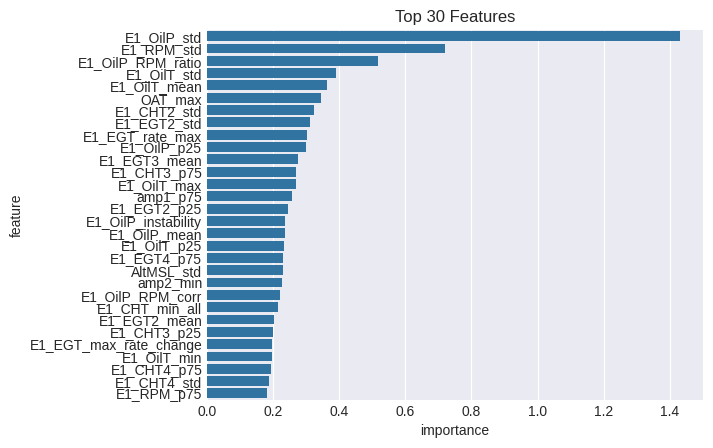

In [110]:
# Plot top features
num_features = 30

sns.barplot(data=features_df.head(num_features), y="feature", x="importance")
plt.title(f"Top {num_features} Features");

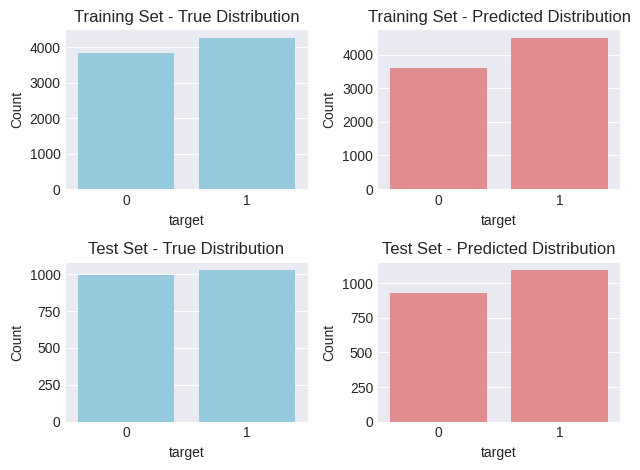

In [111]:
# Analyze class distribution in predictions vs actual
fig, axes = plt.subplots(2, 2)

# Prepare data for plotting
train_actual = y_train.value_counts().reset_index()
train_actual.columns = ["target", "count"]

train_pred = pd.Series(y_train_pred).value_counts().reset_index()
train_pred.columns = ["target", "count"]

test_actual = y_test.value_counts().reset_index()
test_actual.columns = ["target", "count"]

test_pred = pd.Series(y_test_pred).value_counts().reset_index()
test_pred.columns = ["target", "count"]

# Train - Actual distribution
ax = axes[0, 0]
sns.barplot(data=train_actual, x="target", y="count", ax=ax, color="skyblue")
ax.set_title("Training Set - True Distribution")
ax.set_ylabel("Count")

# Train - Predicted distribution
ax = axes[0, 1]
sns.barplot(data=train_pred, x="target", y="count", ax=ax, color="lightcoral")
ax.set_title("Training Set - Predicted Distribution")
ax.set_ylabel("Count")

# Test - Actual distribution
ax = axes[1, 0]
sns.barplot(data=test_actual, x="target", y="count", ax=ax, color="skyblue")
ax.set_title("Test Set - True Distribution")
ax.set_ylabel("Count")

# Test - Predicted distribution
ax = axes[1, 1]
sns.barplot(data=test_pred, x="target", y="count", ax=ax, color="lightcoral")
ax.set_title("Test Set - Predicted Distribution")
ax.set_ylabel("Count")

fig.set_layout_engine("tight")

In [112]:
# Save the trained model
# model_path = PROJECT_DIR / "models" / f"logistic_regression_{hierarchy}.pkl"
model_path = PROJECT_DIR / "models" / "logistic_regression_addtl_features.pkl"
model_path.parent.mkdir(exist_ok=True, parents=True)

joblib.dump(log_clf, model_path)

['/home/alex/Documents/flights/models/logistic_regression_addtl_features.pkl']